#####  Package Imports

In [3]:
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,roc_auc_score,accuracy_score
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

Reading Training data

In [4]:
data=pd.read_csv("train.csv")

 Checking duplicate data entries

In [5]:
data.duplicated().sum()

0

identifying missing values

In [6]:
data.isnull().sum()

ID                         0
Gender                     1
Age                        1
Region_Code                1
Occupation                 1
Channel_Code               1
Vintage                    1
Credit_Product         13394
Avg_Account_Balance        1
Is_Active                  1
Is_Lead                    1
dtype: int64


Replacing blank entries with Missing label


In [7]:
data['Credit_Product']= data['Credit_Product'].fillna('Missing')

Renaming data fields with common lables to avoid confusion

In [8]:
mapper = {'Yes': 'Credit_Product_Yes','No': 'Credit_Product_No', 'Missing':'Credit_Product_Missing'}
data['Credit_Product'] = data['Credit_Product'].map(mapper)
mapper2 = {'Yes': 'Is_Active_Yes','No': 'Is_Active_No'}
data['Is_Active'] = data['Is_Active'].map(mapper2)

Dropping ID and other NAN values as ID is uniform distribution and is never correlated with target features

In [9]:
data.drop('ID',axis=1,inplace=True)
data.dropna(inplace=True)

One Hot encoding of categorical labels other than Region_code

In [10]:
cat_cols = ['Gender','Occupation','Channel_Code','Credit_Product','Is_Active']
encoders = {}
ohe = OneHotEncoder(handle_unknown='error', drop='first')

dummies = pd.DataFrame(ohe.fit_transform(data[cat_cols]).toarray(), 
                       index=data.index, 
                       dtype=int
                     )

data=pd.concat([data.drop(cat_cols, axis=1),dummies], axis=1)

In [104]:
data

,Age,Region_Code,Vintage,Avg_Account_Balance,Is_Lead,0,1,2,3,4,5,6,7,8,9
0,73.0,RG268,43.0,1045696.0,0.0,0,1,0,0,0,1,0,1,0,0
1,30.0,RG277,32.0,581988.0,0.0,0,0,1,0,0,0,0,1,0,0
2,56.0,RG268,26.0,1484315.0,0.0,0,0,0,1,0,1,0,1,0,1
3,34.0,RG270,19.0,470454.0,0.0,1,0,1,0,0,0,0,1,0,0
4,30.0,RG282,33.0,886787.0,0.0,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112171,34.0,RG284,21.0,1551430.0,0.0,1,0,1,0,0,0,0,1,0,1
112172,34.0,RG272,21.0,298194.0,0.0,0,0,1,0,0,0,0,1,0,0
112173,45.0,RG261,26.0,1567201.0,0.0,0,0,0,0,0,1,0,0,1,0
112174,51.0,RG268,104.0,708849.0,0.0,0,0,0,1,0,1,0,1,0,1


Seperating predictors and target labels

In [11]:
y=data['Is_Lead']
X= data.drop('Is_Lead',axis=1)

#### Region_code has high cardinality hence converting to one hot encoded values can lead to curse of dimension.
#### Hence, using embedding vectors to map categorical features to numerical value

Ordinal encoding of the Region_Code 

In [12]:
encoder = LabelEncoder()
X['Region_Code']= encoder.fit_transform(X['Region_Code'])

Creating a neural network with input as Region COde values and target and the output as Is_Lead.
Included embedding layer in the input to learn mapping of categorical values to numerical embeddings.
Chose 7 as the size of embeddings as 2**7 128 and is suffient to hold 35 different labels as present in the feature Region_Code.
used binary cross entrophy as the loss function and adam optimiser for faster learing.
Used 4 epochs as no further improvement is observed.


In [13]:
in_layer = Input(shape=(1,))
em_layer = Embedding(35, 7)(in_layer)

# concat all embeddings

dense = Dense(10, activation='relu', kernel_initializer='he_normal')(em_layer)
output = Dense(1, activation='sigmoid')(dense)
model = Model(inputs=in_layer, outputs=output)
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# plot graph

# fit the keras model on the dataset
model.fit(X['Region_Code'], y, epochs=4, batch_size=16, verbose=2)

Train on 112176 samples
Epoch 1/4
112176/112176 - 9s - loss: 0.5438 - accuracy: 0.7616
Epoch 2/4
112176/112176 - 8s - loss: 0.5413 - accuracy: 0.7619
Epoch 3/4
112176/112176 - 8s - loss: 0.5412 - accuracy: 0.7619
Epoch 4/4
112176/112176 - 8s - loss: 0.5411 - accuracy: 0.7619


Extracting mapping of lables from the embedding layer of the model.
further concatinating with the orignal data set

In [14]:
get_1st_layer_output = K.function([model.layers[0].input],
                                  [model.layers[1].output])
region_code_mapper = {}
for i in X['Region_Code'].unique():
    region_code_mapper[i] = get_1st_layer_output([i])[0]
mapped_data = X['Region_Code'].map(region_code_mapper) 

X=pd.concat([X,pd.DataFrame( pd.DataFrame(mapped_data).Region_Code.tolist(),columns=['R1','R2','R3','R4','R5','R6','R7'])],axis=1)

Removing region code and the data value is already captured in embeddings

In [15]:
X.drop('Region_Code',axis=1)

,Age,Vintage,Avg_Account_Balance,0,1,2,3,4,5,6,7,8,9,R1,R2,R3,R4,R5,R6,R7
0,73.0,43.0,1045696.0,0,1,0,0,0,1,0,1,0,0,0.021195,-0.071517,-0.087096,0.012138,0.089522,0.007455,-0.158493
1,30.0,32.0,581988.0,0,0,1,0,0,0,0,1,0,0,-0.080239,0.006189,0.056109,-0.043308,-0.083461,0.115604,0.069854
2,56.0,26.0,1484315.0,0,0,0,1,0,1,0,1,0,1,0.021195,-0.071517,-0.087096,0.012138,0.089522,0.007455,-0.158493
3,34.0,19.0,470454.0,1,0,1,0,0,0,0,1,0,0,-0.011500,0.145096,0.277920,0.030222,-0.238168,0.085744,0.286664
4,30.0,33.0,886787.0,0,0,1,0,0,0,0,1,0,0,0.025710,0.132476,0.122017,0.097736,-0.099300,0.111087,0.180930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112171,34.0,21.0,1551430.0,1,0,1,0,0,0,0,1,0,1,-0.120177,-0.119749,-0.058846,-0.065035,0.096859,-0.037677,-0.118641
112172,34.0,21.0,298194.0,0,0,1,0,0,0,0,1,0,0,0.115324,0.078679,0.093056,-0.021021,-0.107201,-0.029230,0.114389
112173,45.0,26.0,1567201.0,0,0,0,0,0,1,0,0,1,0,-0.075648,0.191853,0.227079,-0.065040,-0.252258,0.205873,0.265938
112174,51.0,104.0,708849.0,0,0,0,1,0,1,0,1,0,1,0.021195,-0.071517,-0.087096,0.012138,0.089522,0.007455,-0.158493


plotting heatmap to check if multicollinerity is present amongst features other than embeddings

<AxesSubplot:>

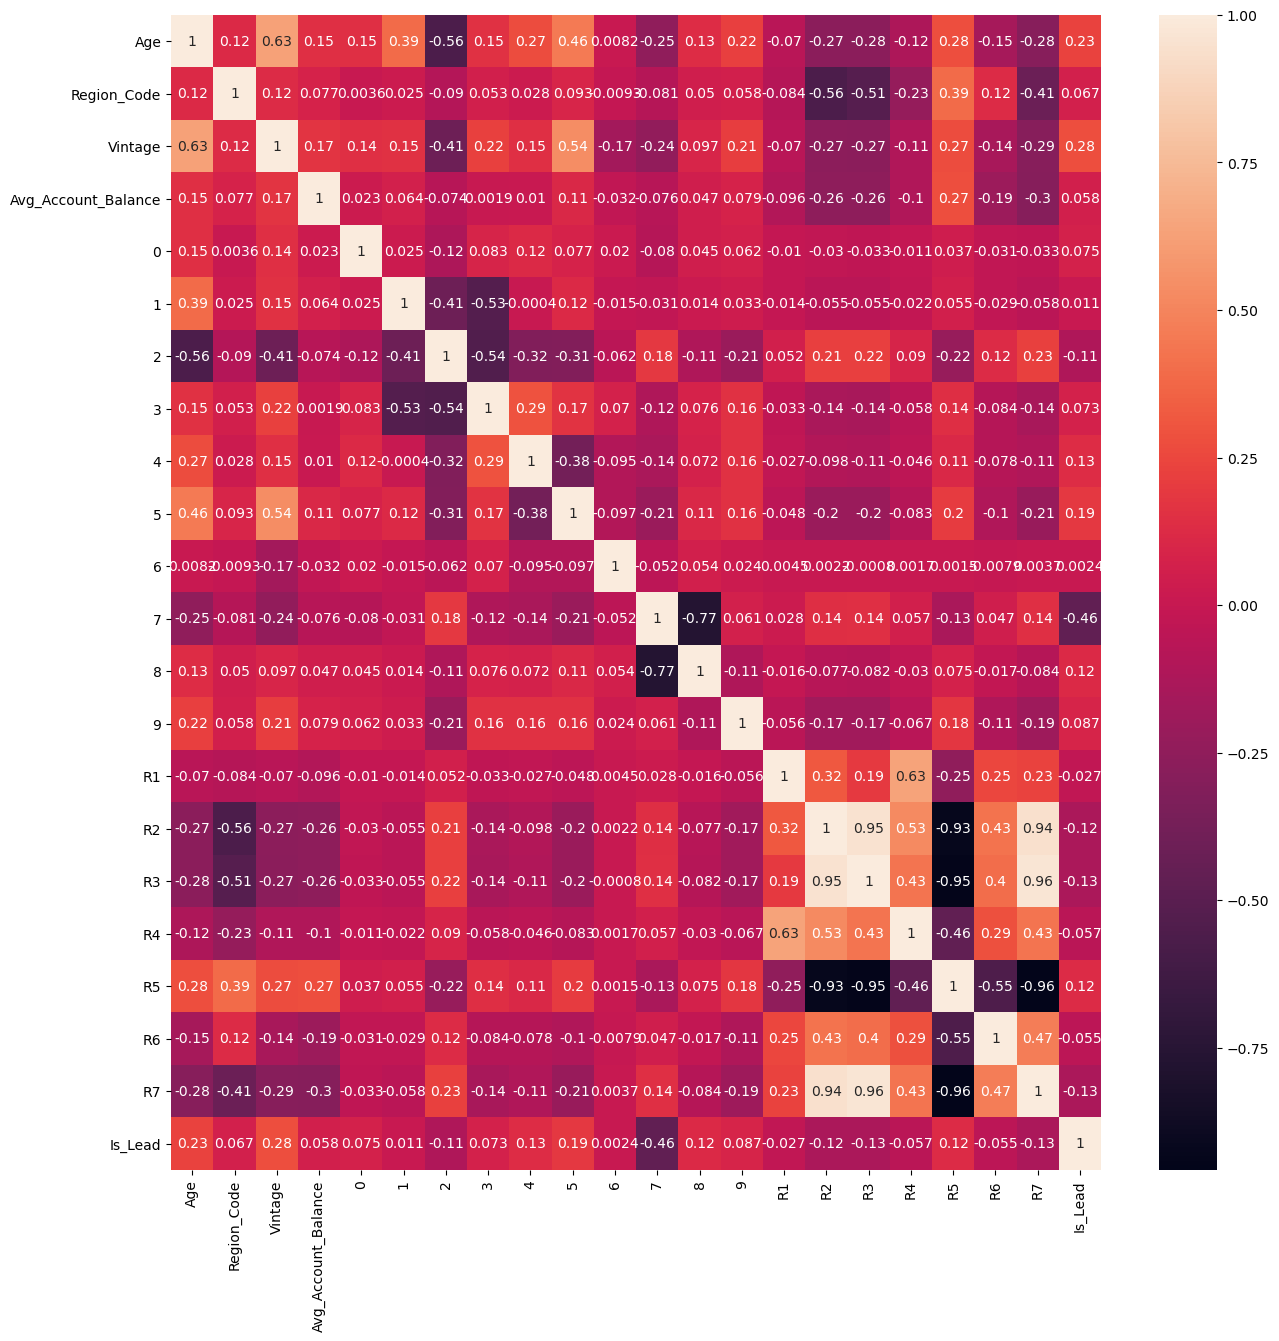

In [16]:
fig, ax = plt.subplots(figsize=(15,15)) 
S= pd.concat([X,y],axis=1)
sns.heatmap(S.corr(),annot=True)

It has been observed that other than embeddings no significant collinerity is observed amongst predictors hence will be using all features for predicting the results

As the data is imbalanced, in order to balance the data over sampling of data items with less frequency is must.
Using SMOTE to generate synthetic data and balance the data

In [17]:
smk = SMOTETomek(random_state=42)
X_res,y_res=smk.fit_resample(X,y)

%50 ratio is observed

In [113]:
y_res.sum()/y_res.count()

0.5

splitting the trainning and test set

In [18]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X_res,y_res,test_size=0.20,random_state=0)

No need of removing outliers and scaling the continous variables as the approch that is being used is random forest classifier 
which is robust to scale and outliers

Hyperparameter tuning using the randomised search cv to obtain the best hyperparamaters for tuning the model

In [205]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 1000,10)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10,14]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4,6,8]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              'criterion':['entropy','gini']}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 120, 230, 340, 450, 560, 670, 780, 890, 1000], 'min_samples_split': [2, 5, 10, 14], 'min_samples_leaf': [1, 2, 4, 6, 8], 'criterion': ['entropy', 'gini']}


Random grid is initialised

fit the data to the random search with cross validations to find best parameters for random forest classifier

In [19]:
X_train,X_test,y_train,y_test=train_test_split(X_res,y_res,test_size=0.30,random_state=0)
model=RandomForestClassifier(n_estimators=2000,criterion='gini',
                             max_features='sqrt',min_samples_leaf=1,random_state=100,min_samples_split=14).fit(X_train,y_train)
predictions=model.predict(X_test)
print(confusion_matrix(y_test,predictions))
print(accuracy_score(y_test,predictions))
print(classification_report(y_test,predictions))
print(roc_auc_score(y_test,predictions))

[[21144  1305]
 [ 2830 20000]]
0.908677311778087
              precision    recall  f1-score   support

         0.0       0.88      0.94      0.91     22449
         1.0       0.94      0.88      0.91     22830

    accuracy                           0.91     45279
   macro avg       0.91      0.91      0.91     45279
weighted avg       0.91      0.91      0.91     45279

0.9089542662594713


roc_auc_Score obtained is around 90 for the test data predictions

### Test data

preprocessing on the test data items. The encoders used are same as that fitted on the training data

In [34]:
test_data = pd.read_csv('test.csv')
test_data['Credit_Product']= test_data['Credit_Product'].fillna('Missing')
mapper = {'Yes': 'Credit_Product_Yes','No': 'Credit_Product_No', 'Missing':'Credit_Product_Missing'}
test_data['Credit_Product'] = test_data['Credit_Product'].map(mapper)
mapper2 = {'Yes': 'Is_Active_Yes','No': 'Is_Active_No'}
test_data['Is_Active'] = test_data['Is_Active'].map(mapper2)
test_data.drop('ID',axis=1,inplace=True)
test_data.dropna(inplace=True)

In [35]:
test_data

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
0,Male,29,RG254,Other,X1,25,Credit_Product_Yes,742366,Is_Active_No
1,Male,43,RG268,Other,X2,49,Credit_Product_Missing,925537,Is_Active_No
2,Male,31,RG270,Salaried,X1,14,Credit_Product_No,215949,Is_Active_No
3,Male,29,RG272,Other,X1,33,Credit_Product_No,868070,Is_Active_No
4,Female,29,RG270,Other,X1,19,Credit_Product_No,657087,Is_Active_No
...,...,...,...,...,...,...,...,...,...
105307,Male,52,RG268,Salaried,X2,86,Credit_Product_Yes,4242558,Is_Active_Yes
105308,Male,55,RG277,Other,X2,86,Credit_Product_Yes,1159153,Is_Active_No
105309,Male,35,RG254,Salaried,X4,15,Credit_Product_No,1703727,Is_Active_No
105310,Male,53,RG254,Other,X3,93,Credit_Product_No,737178,Is_Active_Yes


one hot encoding for the test data

In [36]:
cat_cols = ['Gender','Occupation','Channel_Code','Credit_Product','Is_Active']

dummies = pd.DataFrame(ohe.transform(test_data[cat_cols]).toarray(), 
                       index=test_data.index, 
                       dtype=int
                     )

In [37]:
test_data=pd.concat([test_data.drop(cat_cols, axis=1),dummies], axis=1)

In [39]:
test_data

,Age,Region_Code,Vintage,Avg_Account_Balance,0,1,2,3,4,5,6,7,8,9
0,29,4,25,742366,1,1,0,0,0,0,0,0,1,0
1,43,18,49,925537,1,1,0,0,1,0,0,0,0,0
2,31,20,14,215949,1,0,1,0,0,0,0,1,0,0
3,29,22,33,868070,1,1,0,0,0,0,0,1,0,0
4,29,20,19,657087,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105307,52,18,86,4242558,1,0,1,0,1,0,0,0,1,1
105308,55,27,86,1159153,1,1,0,0,1,0,0,0,1,0
105309,35,4,15,1703727,1,0,1,0,0,0,1,1,0,0
105310,53,4,93,737178,1,1,0,0,0,1,0,1,0,1


Mapping region code to the learned embedding vector

In [38]:
test_data['Region_Code']= encoder.transform(test_data['Region_Code'])

In [40]:
mapped_data = test_data['Region_Code'].map(region_code_mapper) 
test_data=pd.concat([test_data,pd.DataFrame( pd.DataFrame(mapped_data).Region_Code.tolist(),columns=['R1','R2','R3','R4','R5','R6','R7'])],axis=1)

In [146]:
test_data

,Age,Region_Code,Vintage,Avg_Account_Balance,0,1,2,3,4,5,...,7,8,9,R1,R2,R3,R4,R5,R6,R7
0,29,4,25,742366,1,1,0,0,0,0,...,0,1,0,-0.033171,-0.148669,0.060589,-0.132989,-0.125547,-0.058274,0.013714
1,43,18,49,925537,1,1,0,0,1,0,...,0,0,0,-0.050292,0.073896,0.011364,0.035949,0.030337,0.047866,0.035118
2,31,20,14,215949,1,0,1,0,0,0,...,1,0,0,0.123184,-0.310342,0.057793,-0.216143,-0.263526,-0.198858,0.039376
3,29,22,33,868070,1,1,0,0,0,0,...,1,0,0,0.116955,-0.110154,-0.036964,-0.055918,-0.104540,-0.028921,-0.074803
4,29,20,19,657087,0,1,0,0,0,0,...,1,0,0,0.123184,-0.310342,0.057793,-0.216143,-0.263526,-0.198858,0.039376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105307,52,18,86,4242558,1,0,1,0,1,0,...,0,1,1,-0.050292,0.073896,0.011364,0.035949,0.030337,0.047866,0.035118
105308,55,27,86,1159153,1,1,0,0,1,0,...,0,1,0,0.064412,-0.128382,-0.059882,-0.068253,-0.074797,-0.016715,0.062632
105309,35,4,15,1703727,1,0,1,0,0,0,...,1,0,0,-0.033171,-0.148669,0.060589,-0.132989,-0.125547,-0.058274,0.013714
105310,53,4,93,737178,1,1,0,0,0,1,...,1,0,1,-0.033171,-0.148669,0.060589,-0.132989,-0.125547,-0.058274,0.013714


Fitting the model to the complete training data

In [41]:
model=RandomForestClassifier(n_estimators=2000,criterion='gini',
                             max_features='sqrt',min_samples_leaf=1,random_state=100,min_samples_split=14,max_depth=10).fit(X_res,y_res)


Making predictions on test data and replacing the target variables in the submission file

In [42]:
predictions=model.predict(test_data)
submission = pd.read_csv('sample_submission.csv')
submission['Is_Lead'] =predictions
submission['Is_Lead']=submission.Is_Lead.astype(int)
submission.to_csv('sample_submission.csv',index=None)